In [3]:
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, RobustScaler, MinMaxScaler

In [4]:
df = pd.read_csv("../data/cleaned-scientometrics-and-bibliometrics-research.csv", low_memory=False)

In [5]:
df['topics.display_name'] = df['topics.display_name'].apply(lambda x: ast.literal_eval(x))
df['topics.score'] = df['topics.score'].apply(lambda x: ast.literal_eval(x))

In [6]:
df

,title,publication_year,cited_by_count,topics.display_name,topics.score,cited_by_count_norm,publication_year_norm,publication_year_quartile,cited_by_count_quartile,log_cite
0,How to conduct a bibliometric analysis: An ove...,2021,6635,[scientometrics and bibliometrics research],[0.9736],1.000000,0.996341,0.838384,1.000000,8.800265
1,Analyzing the past to prepare for the future: ...,2002,6002,"[scientometrics and bibliometrics research, De...","[0.8112, 0.8084, 0.7988]",0.987637,0.978037,0.196970,1.000000,8.700015
2,Co‐citation in the scientific literature: A ne...,1973,4591,[scientometrics and bibliometrics research],[0.9994],0.954593,0.946613,0.118967,1.000000,8.432071
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.930270,0.983010,0.247475,0.998102,8.234830
4,The journal coverage of Web of Science and Sco...,2015,3167,"[scientometrics and bibliometrics research, Ac...","[0.9994, 0.9448, 0.9224]",0.908817,0.990731,0.570707,0.996712,8.060856
...,...,...,...,...,...,...,...,...,...,...
50022,Issue Publication Information,2018,0,[scientometrics and bibliometrics research],[0.5676],0.000000,0.993555,0.737374,0.000000,0.000000
50023,W. A. TAYLOR and CO.,1961,0,"[scientometrics and bibliometrics research, Ir...","[0.8668, 0.8155, 0.7664]",0.000000,0.932099,0.101010,0.000000,0.000000
50024,VARIAN associates,1962,0,"[scientometrics and bibliometrics research, In...","[0.2804, 0.2517]",0.000000,0.933348,0.103030,0.000000,0.000000
50025,scientific products,1963,0,[scientometrics and bibliometrics research],[0.315],0.000000,0.934589,0.105051,0.000000,0.000000


In [7]:
df['cited_by_count_quartile'].describe()

count    50027.000000
mean         0.398642
std          0.379070
min          0.000000
25%          0.000000
50%          0.500000
75%          0.752525
max          1.000000
Name: cited_by_count_quartile, dtype: float64

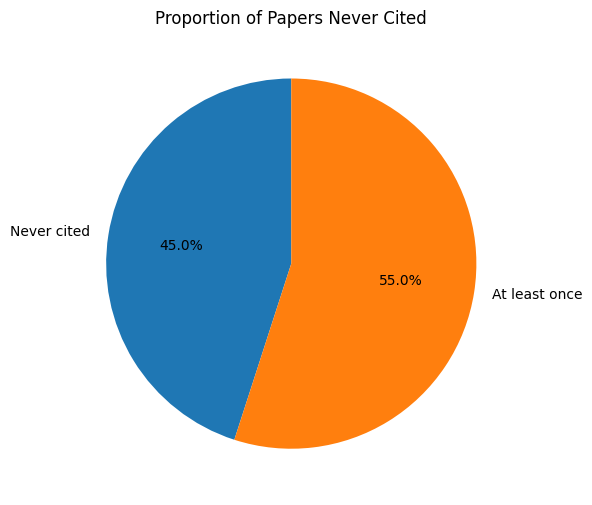

In [15]:
import matplotlib.pyplot as plt

# Compute counts
never = (df['cited_by_count'] == 0).sum()
ever  = len(df) - never

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [never, ever],
    labels=['Never cited', 'At least once'],
    autopct='%1.1f%%',
    startangle=90,
)
plt.title('Proportion of Papers Never Cited')
plt.tight_layout()

plt.savefig(
        "export_images/Proportion of Papers Never Cited.png",
        dpi=300,               # resolution in dots per inch
        bbox_inches="tight"    # trim extra whitespace
    )

plt.show()

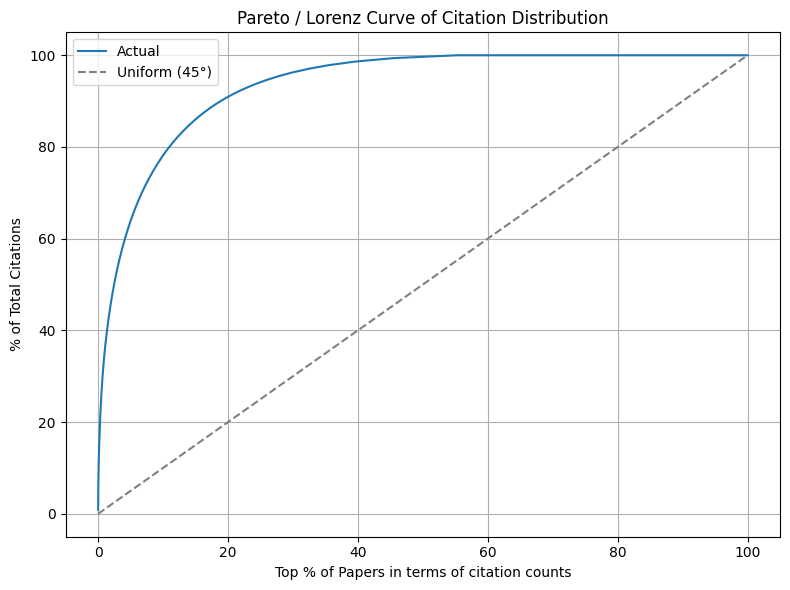

In [21]:
# 1) Sort descending
df_sorted = df.sort_values('cited_by_count', ascending=False).reset_index(drop=True)

# 2) cumulative citations and normalized
total_cites = df_sorted['cited_by_count'].sum()
df_sorted['cum_cites'] = df_sorted['cited_by_count'].cumsum()
df_sorted['cum_cite_pct'] = df_sorted['cum_cites'] / total_cites * 100

# 3) cumulative fraction of papers
n = len(df_sorted)
df_sorted['paper_pct'] = (np.arange(1, n+1) / n) * 100

# 4) plot
plt.figure(figsize=(8, 6))
plt.plot(df_sorted['paper_pct'], df_sorted['cum_cite_pct'], label='Actual')
plt.plot([0, 100], [0, 100], '--', color='gray', label='Uniform (45°)')

plt.xlabel('Top % of Papers in terms of citation counts')
plt.ylabel('% of Total Citations')
plt.title('Pareto / Lorenz Curve of Citation Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(
        "export_images/Citation Concentration.png",
        dpi=300,               # resolution in dots per inch
        bbox_inches="tight"    # trim extra whitespace
    )

plt.show()

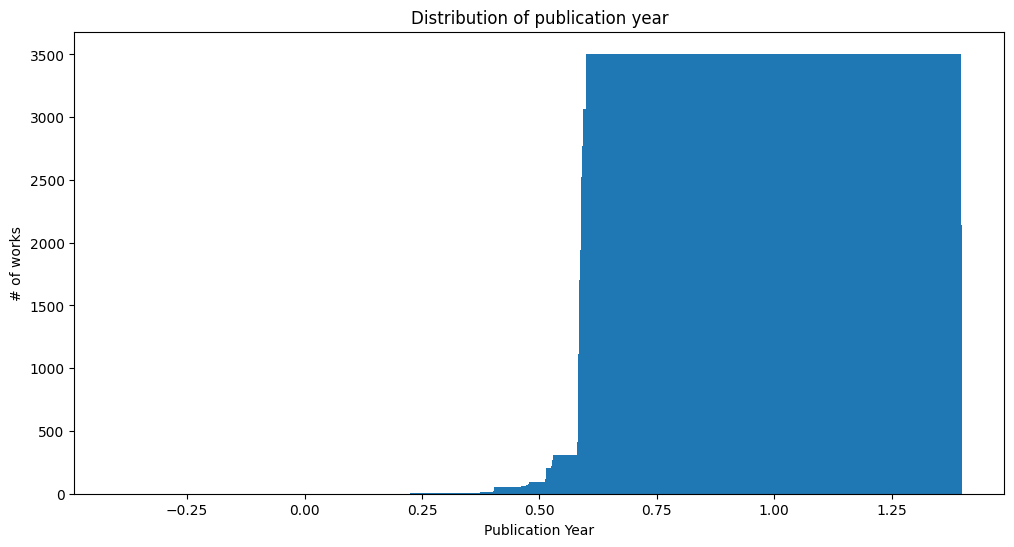

In [11]:
publication_year_count = df['publication_year_norm'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(publication_year_count.index, publication_year_count.values)
plt.title("Distribution of publication year")
plt.xlabel("Publication Year")
plt.ylabel("# of works")
plt.show()

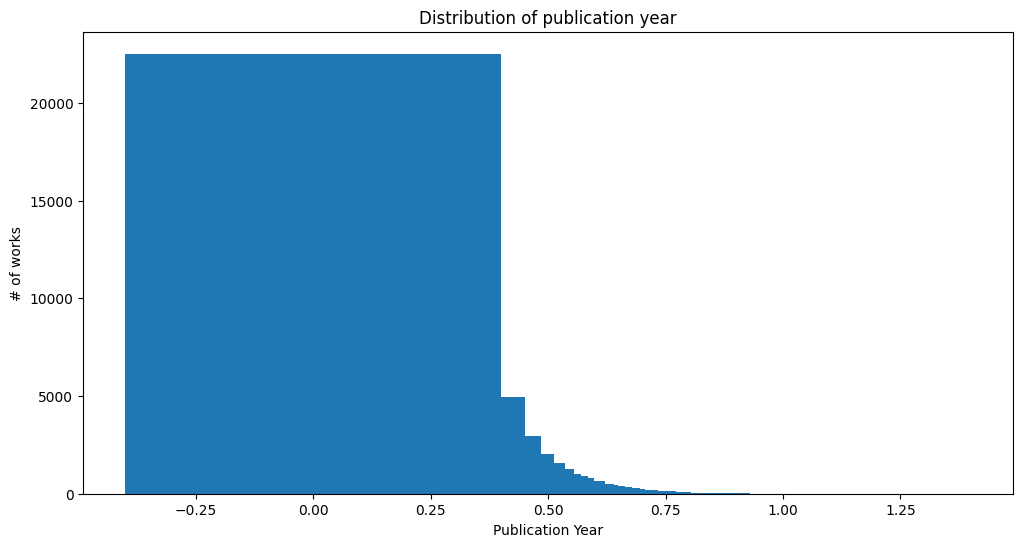

In [12]:
publication_year_count = df['cited_by_count_norm'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(publication_year_count.index, publication_year_count.values)
plt.title("Distribution of publication year")
plt.xlabel("Publication Year")
plt.ylabel("# of works")
plt.show()

In [34]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
years = df[['publication_year']].values
transformed = qt.fit_transform(years).flatten()

In [35]:
transformed

array([0.83838384, 0.1969697 , 0.11896745, ..., 0.1030303 , 0.10505051,
       0.1010101 ], shape=(50027,))

In [36]:
df['publication_year_quartile'] = transformed

In [37]:
df

,title,publication_year,cited_by_count,topics.display_name,topics.score,cited_by_count_norm,publication_year_norm,publication_year_quartile
0,How to conduct a bibliometric analysis: An ove...,2021,6635,[scientometrics and bibliometrics research],[0.9736],1.000000,0.996341,0.838384
1,Analyzing the past to prepare for the future: ...,2002,6002,"[scientometrics and bibliometrics research, De...","[0.8112, 0.8084, 0.7988]",0.987637,0.978037,0.196970
2,Co‐citation in the scientific literature: A ne...,1973,4591,[scientometrics and bibliometrics research],[0.9994],0.954593,0.946613,0.118967
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.930270,0.983010,0.247475
4,The journal coverage of Web of Science and Sco...,2015,3167,"[scientometrics and bibliometrics research, Ac...","[0.9994, 0.9448, 0.9224]",0.908817,0.990731,0.570707
...,...,...,...,...,...,...,...,...
50022,Issue Publication Information,2018,0,[scientometrics and bibliometrics research],[0.5676],0.000000,0.993555,0.737374
50023,W. A. TAYLOR and CO.,1961,0,"[scientometrics and bibliometrics research, Ir...","[0.8668, 0.8155, 0.7664]",0.000000,0.932099,0.101010
50024,VARIAN associates,1962,0,"[scientometrics and bibliometrics research, In...","[0.2804, 0.2517]",0.000000,0.933348,0.103030
50025,scientific products,1963,0,[scientometrics and bibliometrics research],[0.315],0.000000,0.934589,0.105051


In [38]:
qt = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
norm_years = df[['cited_by_count']].values
transformed = qt.fit_transform(norm_years).flatten()

In [43]:
df['cited_by_count_quartile'] = transformed

In [44]:
df

,title,publication_year,cited_by_count,topics.display_name,topics.score,cited_by_count_norm,publication_year_norm,publication_year_quartile,cited_by_count_quartile
0,How to conduct a bibliometric analysis: An ove...,2021,6635,[scientometrics and bibliometrics research],[0.9736],1.000000,0.996341,0.838384,1.000000
1,Analyzing the past to prepare for the future: ...,2002,6002,"[scientometrics and bibliometrics research, De...","[0.8112, 0.8084, 0.7988]",0.987637,0.978037,0.196970,1.000000
2,Co‐citation in the scientific literature: A ne...,1973,4591,[scientometrics and bibliometrics research],[0.9994],0.954593,0.946613,0.118967,1.000000
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.930270,0.983010,0.247475,0.998102
4,The journal coverage of Web of Science and Sco...,2015,3167,"[scientometrics and bibliometrics research, Ac...","[0.9994, 0.9448, 0.9224]",0.908817,0.990731,0.570707,0.996712
...,...,...,...,...,...,...,...,...,...
50022,Issue Publication Information,2018,0,[scientometrics and bibliometrics research],[0.5676],0.000000,0.993555,0.737374,0.000000
50023,W. A. TAYLOR and CO.,1961,0,"[scientometrics and bibliometrics research, Ir...","[0.8668, 0.8155, 0.7664]",0.000000,0.932099,0.101010,0.000000
50024,VARIAN associates,1962,0,"[scientometrics and bibliometrics research, In...","[0.2804, 0.2517]",0.000000,0.933348,0.103030,0.000000
50025,scientific products,1963,0,[scientometrics and bibliometrics research],[0.315],0.000000,0.934589,0.105051,0.000000


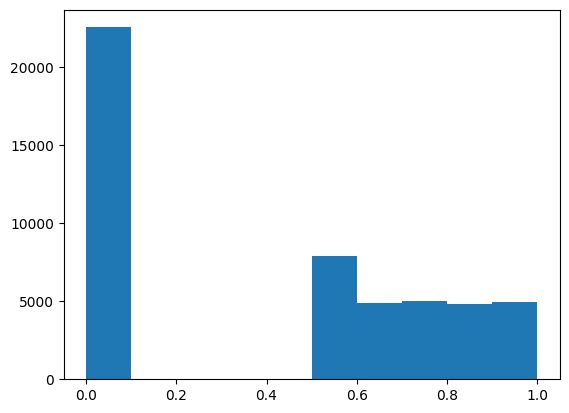

In [45]:
plt.hist(transformed)
plt.show()

In [54]:
pd.Series(transformed).describe()

count    50027.000000
mean         0.398642
std          0.379070
min          0.000000
25%          0.000000
50%          0.500000
75%          0.752525
max          1.000000
dtype: float64

In [22]:
full_df = pd.read_csv("../data/scientometrics-and-bibliometrics-research.csv", low_memory=False)

In [26]:
full_df[['citation_normalized_percentile.value', 'citation_normalized_percentile']]

,citation_normalized_percentile.value,citation_normalized_percentile
0,0.999763,NaN
1,0.962264,NaN
2,0.998292,NaN
3,0.972137,NaN
4,0.999776,NaN
...,...,...
50195,0.000000,NaN
50196,0.000000,NaN
50197,0.000000,NaN
50198,0.000000,NaN


In [24]:
list(full_df.columns)

['id',
 'doi',
 'title',
 'display_name',
 'publication_year',
 'publication_date',
 'language',
 'type',
 'type_crossref',
 'indexed_in',
 'countries_distinct_count',
 'institutions_distinct_count',
 'corresponding_author_ids',
 'corresponding_institution_ids',
 'apc_paid',
 'fwci',
 'has_fulltext',
 'cited_by_count',
 'is_retracted',
 'is_paratext',
 'locations_count',
 'datasets',
 'versions',
 'referenced_works_count',
 'referenced_works',
 'related_works',
 'cited_by_api_url',
 'updated_date',
 'created_date',
 'ids.openalex',
 'ids.doi',
 'ids.mag',
 'primary_location.is_oa',
 'primary_location.landing_page_url',
 'primary_location.pdf_url',
 'primary_location.source.id',
 'primary_location.source.display_name',
 'primary_location.source.issn_l',
 'primary_location.source.issn',
 'primary_location.source.is_oa',
 'primary_location.source.is_in_doaj',
 'primary_location.source.is_indexed_in_scopus',
 'primary_location.source.is_core',
 'primary_location.source.host_organization',


In [47]:
df['cited_by_count'].unique()

array([6635, 6002, 4591, 3769, 3167, 3024, 2844, 2701, 2597, 2475, 2216,
       2155, 2076, 1674, 1543, 1528, 1500, 1490, 1402, 1395, 1372, 1338,
       1329, 1328, 1303, 1280, 1260, 1252, 1251, 1231, 1227, 1180, 1158,
       1147, 1145, 1144, 1094, 1073, 1054, 1043, 1028, 1014,  987,  978,
        942,  929,  922,  905,  901,  899,  888,  875,  870,  862,  857,
        830,  826,  825,  817,  811,  808,  797,  792,  789,  782,  778,
        776,  773,  772,  762,  760,  757,  756,  751,  747,  737,  731,
        726,  722,  719,  716,  710,  707,  697,  693,  688,  686,  682,
        677,  671,  667,  647,  641,  637,  629,  625,  620,  618,  615,
        610,  609,  607,  600,  597,  596,  595,  594,  587,  585,  579,
        577,  575,  574,  570,  568,  567,  561,  560,  559,  551,  548,
        544,  541,  540,  535,  533,  529,  521,  520,  519,  518,  517,
        515,  514,  512,  509,  505,  504,  499,  498,  495,  492,  490,
        489,  488,  483,  482,  480,  479,  477,  4

In [48]:
df['cited_by_count'].value_counts()

cited_by_count
0       22524
1        4928
2        2965
3        2031
4        1551
        ...  
490         1
495         1
498         1
499         1
6635        1
Name: count, Length: 548, dtype: int64

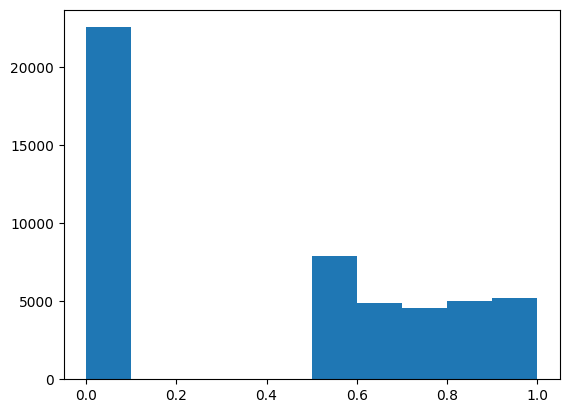

In [50]:
df['log_cite'] = np.log1p(df['cited_by_count'])  # log(1 + x)
qt = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
plt.hist(qt.fit_transform(df[['log_cite']]))
plt.show()

In [55]:
df.to_csv("../data/cleaned-scientometrics-and-bibliometrics-research.csv", header=True, index=False)